# 04-001 : Features - Random Forest Baseline - [0.664] :: 001

Attempt to replicate the results from `001_random-forest-baseline-0-664.ipynb`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import logging
from typing import Any, Dict, List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from tqdm.auto import tqdm

import tensorflow_addons as tfa
import keras as k
from keras import optimizers
import keras_tuner
import keras_tuner as kt

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from competition import data_preparation as dp
from competition import feature_engineering as fe
from competition import model_data as md
from competition import source_data as sd
import competition.models.simple_dense as sd_model
from competition.models.heatmap_covnet import HeatmapCovnetModel

from competition.model_training import mprint, mflush, mclear
from competition.predict import PredictionBase, Baseline, HeatmapPredictor

2023-04-21 12:21:45.574346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Configure Logging

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-04-21 12:21:46 INFO     Started


## Data Collection

In [4]:
# load the source training set
df_source = sd.read_csv('../data/train.csv.gz',
                        compression='gzip',
                        dtype=sd.source_dtype)

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [5]:
# load the source training labels
df_source_labels = sd.read_csv('../data/train_labels.csv')

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

In [8]:
# prepare the main dataset
df_source = dp.prepare_main_dataset(df_source)

# remove sessions with problems
problem_sessions = dp.find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

In [9]:
# prepare the label dataset
df_source_labels = dp.prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

## Feature Engineering

### Develop Features

#### Elapsed Time

In [40]:
# create the initial features
df_features = fe.create_initial_features(df_source, df_source_labels)

# add the elapsed time feature to the features dataset
df_features = fe.add_elapsed_time_features(
    features=df_features,
    X=df_source)

2023-04-21 12:00:52 WARNING  No min/max sum values provided for elapsed_time


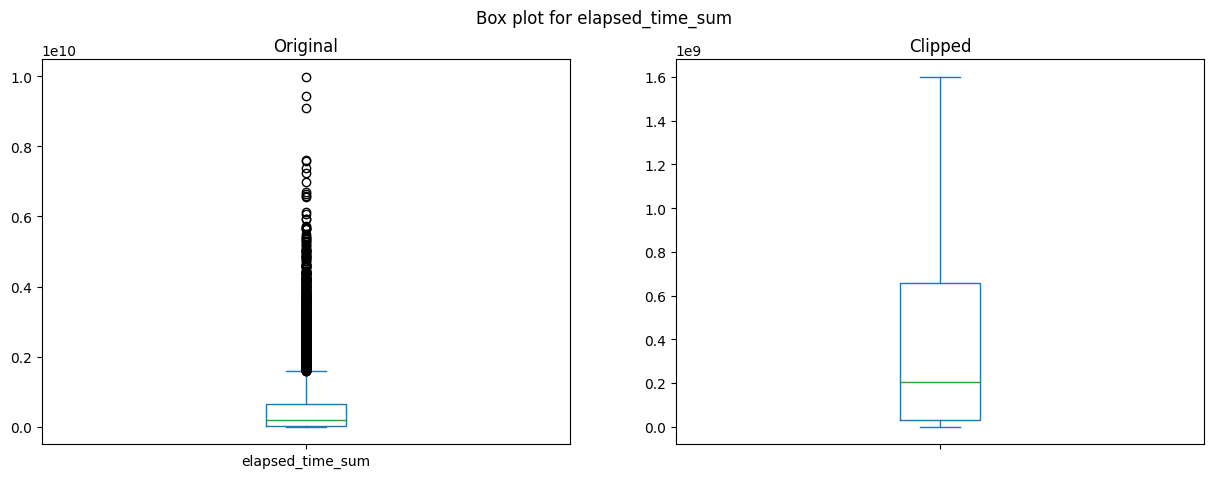

(61395.0, 1601814209.75)

In [41]:
dp.get_clipping_values(df_features, 'elapsed_time_sum', boxplot=True)

In [10]:
# after updating min and max sum values with (61395.0, 1601814209.75) in feature_engineering.py
df_features = fe.create_initial_features(df_source, df_source_labels)
df_features = fe.add_elapsed_time_features(features=df_features, X=df_source)
df_features.describe()

,session_id,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,elapsed_time_std
count,3.494400e+04,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000
mean,2.114901e+16,0.263494,0.333432,0.162174,0.245736,0.196264,0.052266
std,5.582462e+14,0.302038,0.286284,0.215190,0.246732,0.272747,0.061680
min,2.009031e+16,0.000000,0.000268,0.000000,0.000143,0.000000,0.000000
25%,2.101032e+16,0.017644,0.097721,0.000000,0.044469,0.000000,0.020877
50%,2.104031e+16,0.127153,0.237029,0.081975,0.159175,0.086267,0.036992
75%,2.111001e+16,0.410587,0.480559,0.248911,0.362667,0.269858,0.058034
max,2.210022e+16,1.000000,1.000000,1.000000,1.000000,1.000000,0.494973


#### Numeric Features

In [45]:
NUMERIC_COLUMNS = [
    'level',
    'page',
    'room_coor_x',
    'room_coor_y', 
    'screen_coor_x',
    'screen_coor_y',
    'hover_duration'
]

##### Get the max and min values

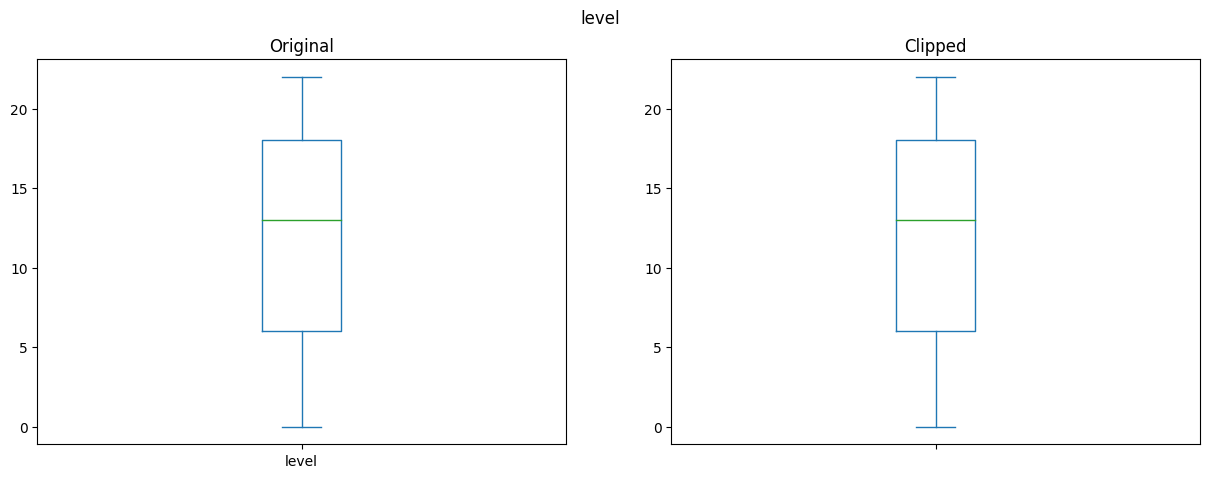

(0.0, 36.0)


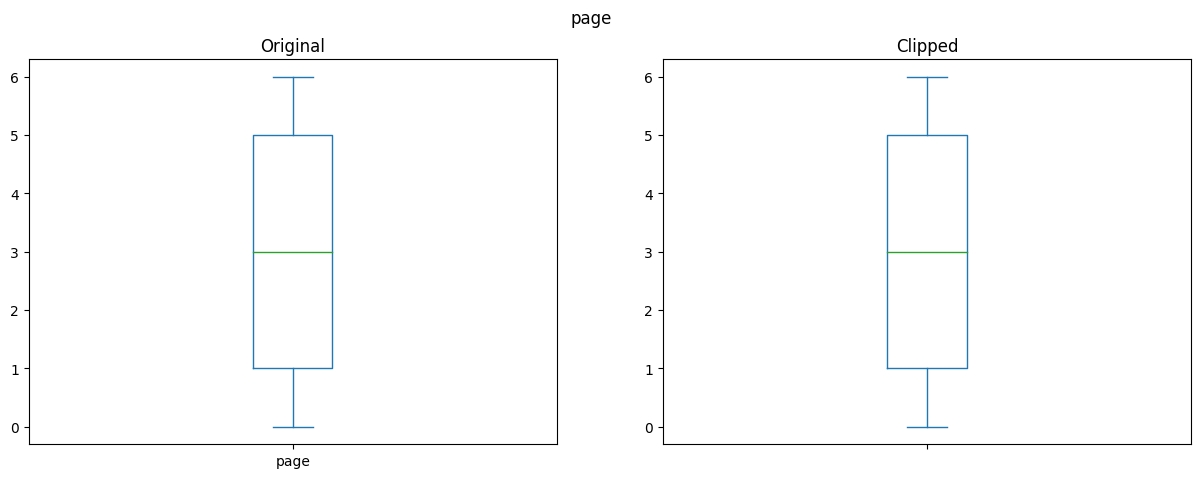

(0.0, 11.0)


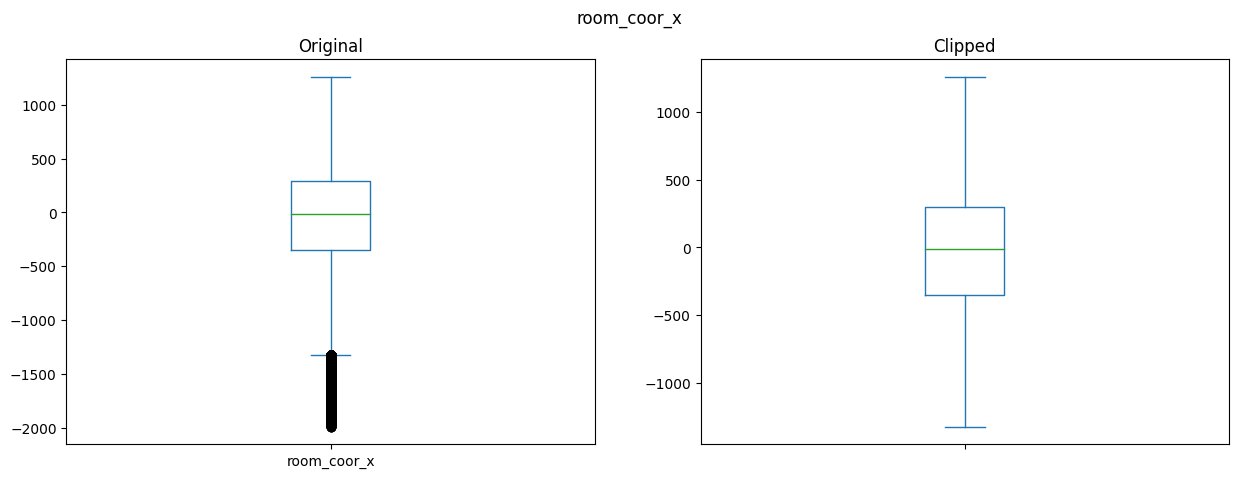

(-1326.9957580566406, 1270.4478454589844)


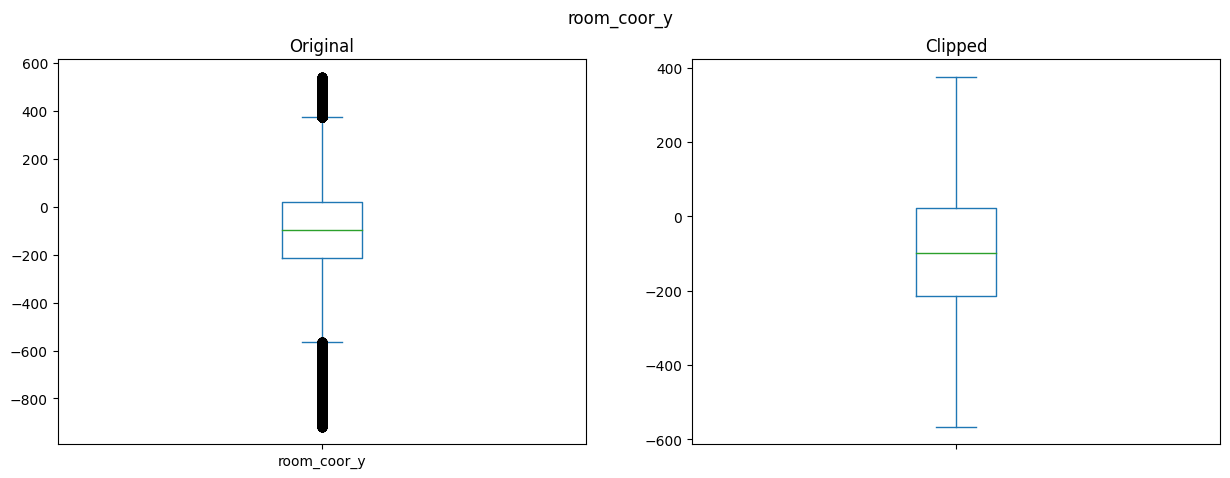

(-566.1585998535156, 375.9445495605469)


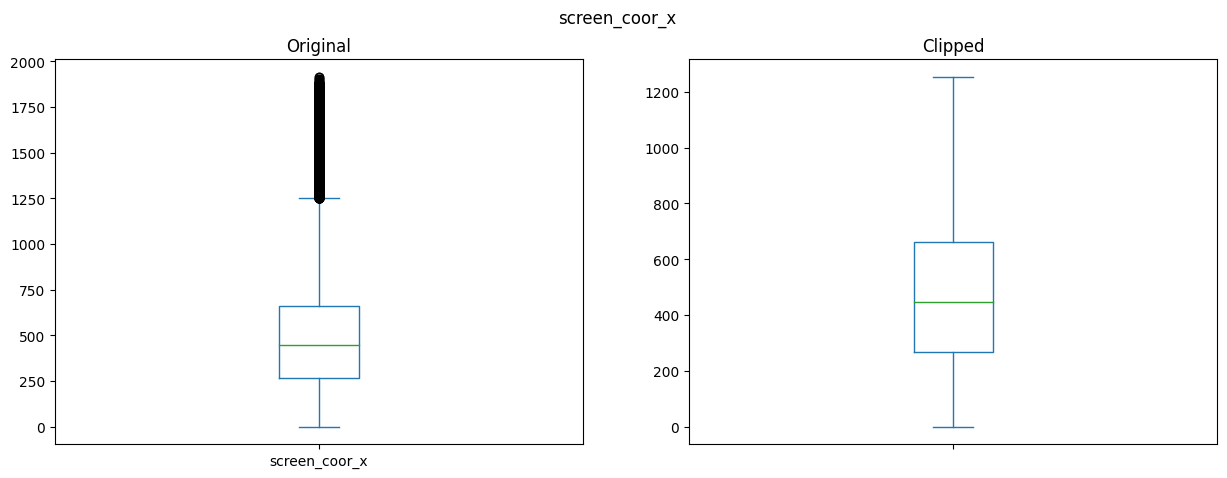

(0.0, 1254.0)


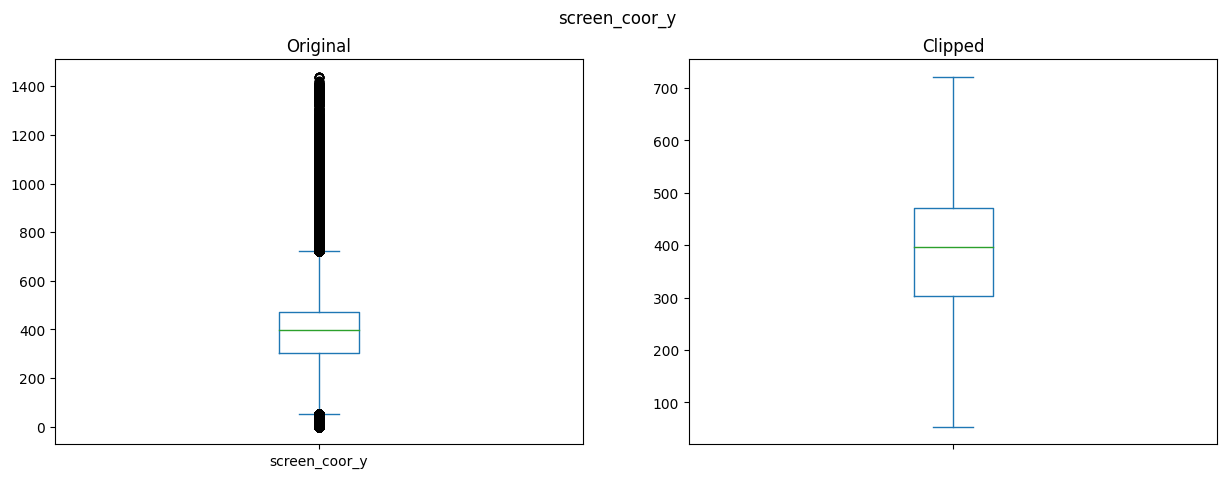

(53.5, 721.5)


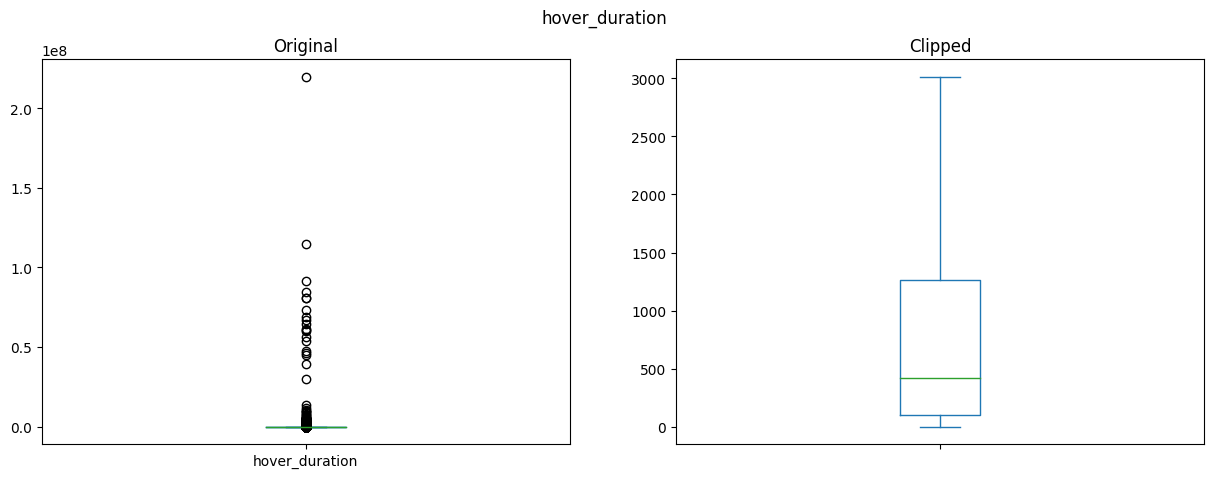

(0.0, 3015.0)


In [48]:
for column in NUMERIC_COLUMNS:
    values = dp.get_clipping_values(df_source, column, boxplot=True)
    print(values)

In [12]:
# add these back to data_preparation.py for clipping and to feature_engineering.py for normalization
NUMERIC_COLUMNS = {
    'level': {'min': 0, 'max': 36},
    'page': {'min': 0, 'max': 11},
    'room_coor_x': {'min': -1327, 'max': 1271},
    'room_coor_y': { 'min': -566, 'max': 376}, 
    'screen_coor_x': {'min': 0, 'max': 1254},
    'screen_coor_y': {'min': 53, 'max': 722},
    'hover_duration': {'min': 0, 'max': 3015}
}

##### Find the sum min and max values

2023-04-21 12:35:58 WARNING  No min/max sum values provided for level


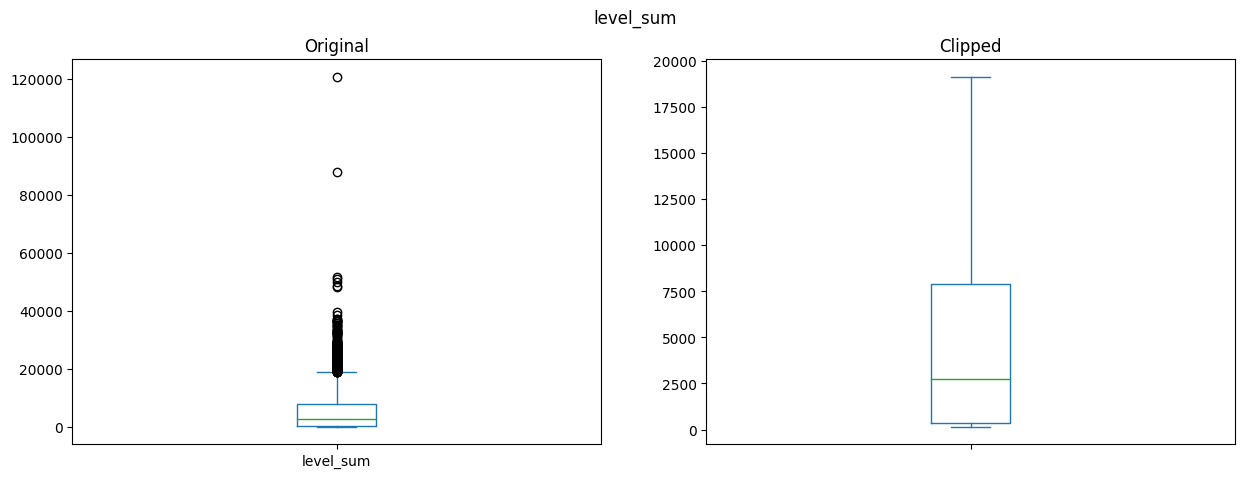

(162.0, 19127.125)
2023-04-21 12:36:02 WARNING  No min/max sum values provided for page


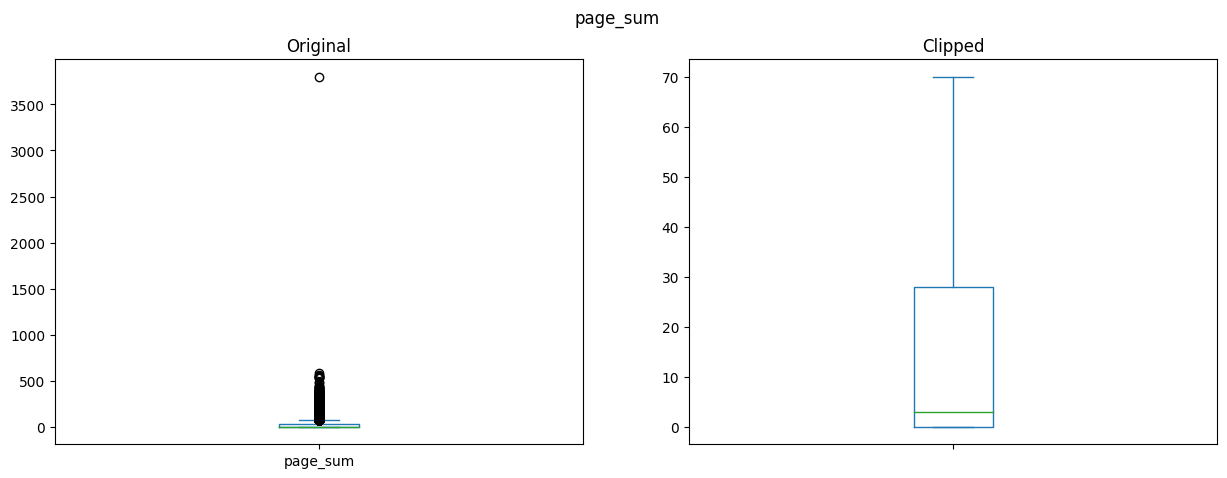

(0.0, 70.0)
2023-04-21 12:36:07 WARNING  No min/max sum values provided for room_coor_x


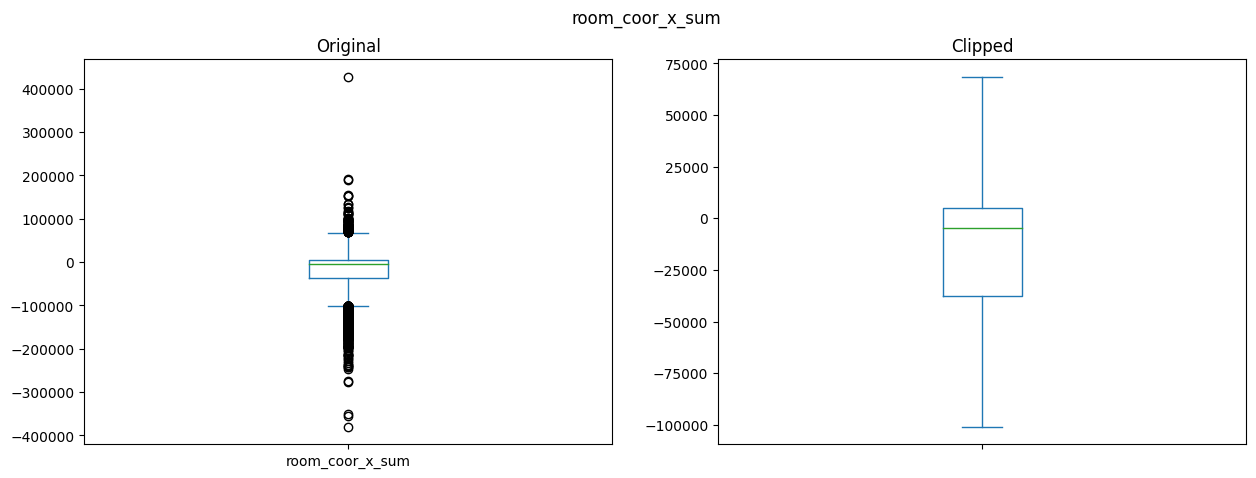

(-100965.96185302734, 68486.1265258789)
2023-04-21 12:36:13 WARNING  No min/max sum values provided for room_coor_y


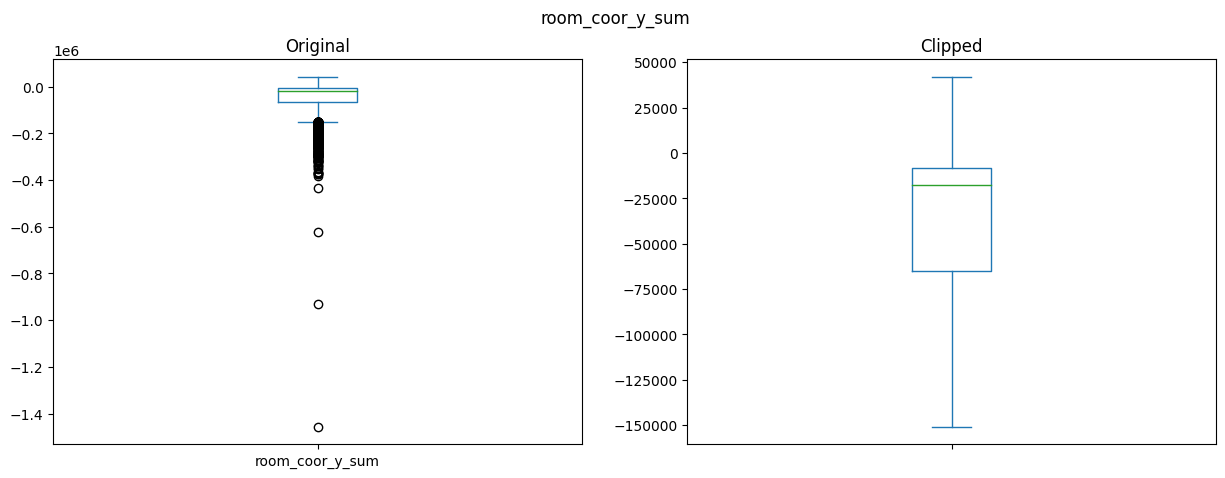

(-150899.54888916016, 77636.5736694336)
2023-04-21 12:36:18 WARNING  No min/max sum values provided for screen_coor_x


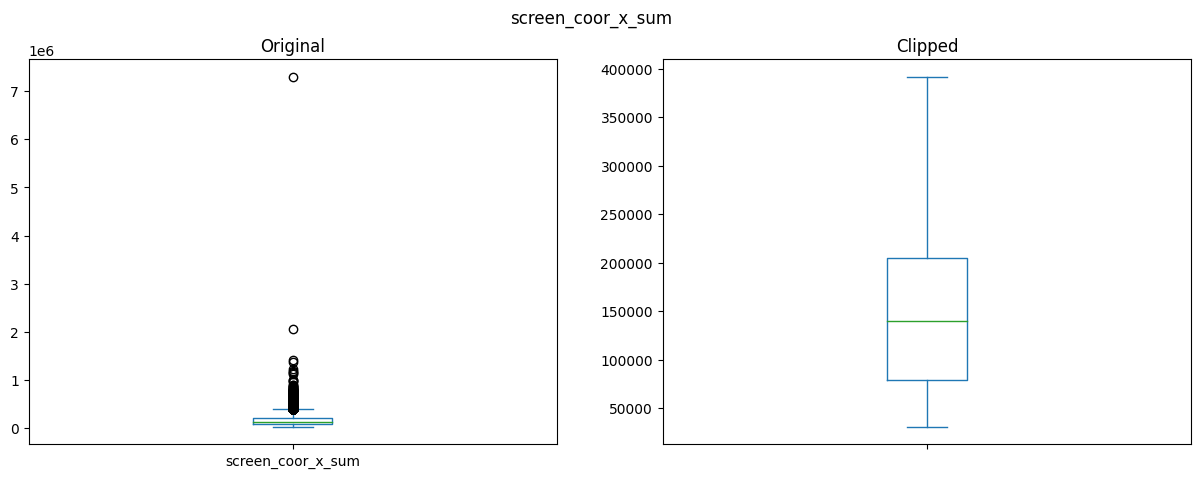

(30805.0, 391498.5)
2023-04-21 12:36:23 WARNING  No min/max sum values provided for screen_coor_y


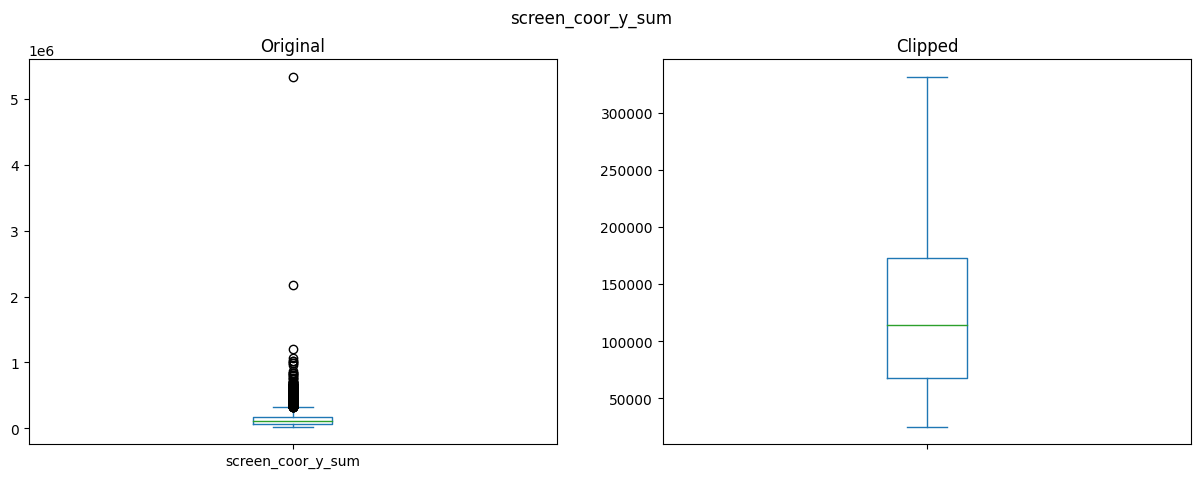

(25153.0, 331596.375)
2023-04-21 12:36:27 WARNING  No min/max sum values provided for hover_duration


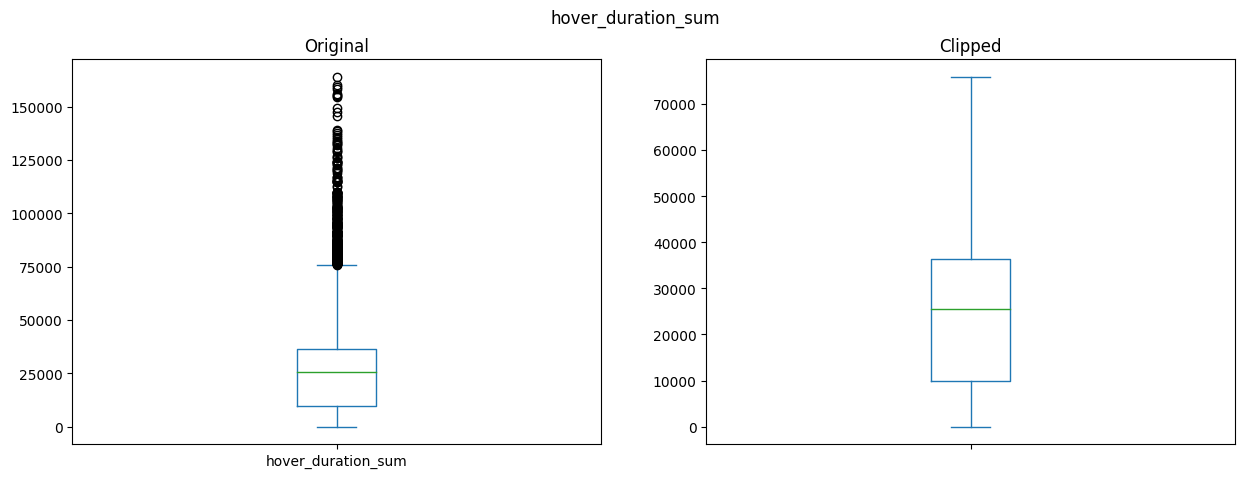

(0.0, 75931.875)


In [21]:
# create the initial features
df_features = fe.create_initial_features(df_source, df_source_labels)

for column, values in NUMERIC_COLUMNS.items():
    # add the features for the column
    df_features = fe.add_numeric_column_features(
        features=df_features,
        X=df_source,
        column=column,
        min_value=values['min'],
        max_value=values['max'])
    
    # get the clipping values for the column sum
    values = dp.get_clipping_values(df_features, f'{column}_sum', boxplot=True)
    print(values)

In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_features.describe())

,session_id,level_sum,level_max,level_min,level_mean,level_mode,level_std,page_sum,page_max,page_min,page_mean,page_mode,page_std,room_coor_x_sum,room_coor_x_max,room_coor_x_min,room_coor_x_mean,room_coor_x_mode,room_coor_x_std,room_coor_y_sum,room_coor_y_max,room_coor_y_min,room_coor_y_mean,room_coor_y_mode,room_coor_y_std,screen_coor_x_sum,screen_coor_x_max,screen_coor_x_min,screen_coor_x_mean,screen_coor_x_mode,screen_coor_x_std,screen_coor_y_sum,screen_coor_y_max,screen_coor_y_min,screen_coor_y_mean,screen_coor_y_mode,screen_coor_y_std,hover_duration_sum,hover_duration_max,hover_duration_min,hover_duration_mean,hover_duration_mode,hover_duration_std
count,3.494400e+04,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,24211.000000,24211.000000,24211.000000,34944.000000,24211.000000,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,3.494400e+04,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,3.494400e+04,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,3.494400e+04,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,32160.000000,32160.000000,32160.000000,34944.000000,32133.000000
mean,2.114901e+16,4541.844609,0.351852,0.166667,0.258686,0.257937,0.053235,25.414320,0.284874,0.171421,0.229747,0.152228,0.045717,-17313.945312,0.910524,0.098493,0.499025,0.353940,0.688511,-3.812991e+04,0.994480,0.107784,0.506213,0.382099,0.786876,1.572635e+05,0.697711,0.010581,0.361866,0.302370,0.191655,1.322111e+05,0.877801,0.001487,0.487704,0.484731,0.105177,25459.250000,0.993122,0.024325,0.368466,0.719277,0.371938
std,5.582462e+14,4793.353981,0.204547,0.148728,0.181227,0.188138,0.013656,53.010666,0.203600,0.171171,0.185232,0.192271,0.040216,36069.488281,0.046390,0.074449,0.029795,0.242003,0.037717,4.352428e+04,0.015173,0.100708,0.068182,0.288397,0.042112,1.033172e+05,0.035673,0.009493,0.032913,0.182740,0.021762,8.742754e+04,0.041079,0.005142,0.050455,0.168192,0.021341,18108.986328,0.045398,0.094539,0.139191,0.443061,0.077413
min,2.009031e+16,162.000000,0.111111,0.000000,0.027337,0.000000,0.019019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-380127.843750,0.831558,0.000000,0.352256,0.000000,0.615296,-1.456729e+06,0.869167,0.000000,0.203025,0.000000,0.694299,3.080500e+04,0.417065,0.000000,0.185043,0.000000,0.107432,2.515300e+04,0.452915,0.000000,0.196147,0.000000,0.026247,0.000000,0.022222,0.000000,0.022222,0.000000,0.000000
25%,2.101032e+16,374.000000,0.111111,0.000000,0.057018,0.083333,0.035990,0.000000,0.090909,0.000000,0.045455,0.000000,0.000000,-37421.428711,0.872157,0.000000,0.478245,0.056204,0.657419,-6.519850e+04,1.000000,0.000000,0.447539,0.000000,0.752220,7.945225e+04,0.687400,0.003190,0.343700,0.167464,0.177360,6.742450e+04,0.865471,0.000000,0.456249,0.384155,0.090850,9880.000000,1.000000,0.005307,0.271409,0.027861,0.326453
50%,2.104031e+16,2767.000000,0.333333,0.138889,0.226218,0.166667,0.058355,3.000000,0.272727,0.090909,0.181818,0.090909,0.046945,-4553.445801,0.891955,0.130231,0.503239,0.439411,0.676977,-1.769161e+04,1.000000,0.095726,0.524175,0.480892,0.771999,1.398515e+05,0.694577,0.007974,0.358614,0.289474,0.190013,1.145300e+05,0.881913,0.000000,0.485790,0.511211,0.103361,25598.500000,1.000000,0.005638,0.339071,1.000000,0.370827
75%,2.111001e+16,7875.250000,0.611111,0.361111,0.488666,0.500000,0.064336,28.000000,0.545455,0.363636,0.434343,0.363636,0.076536,4941.593384,0.961814,0.156376,0.519813,0.517576,0.728693,-8.064472e+03,1.000000,0.189653,0.559283,0.588138,0.829960,2.042708e+05,0.698565,0.015152,0.374953,0.392345,0.203237,1.730932e+05,0.895366,0.000000,0.514549,0.588939,0.117639,36300.750000,1.000000,0.010614,0.432724,1.000000,0.418309
max,2.210022e+16,120797.000000,0.611111,0.361111,0.560953,0.611111,0.088889,3800.000000,0.545455,0.545455,0.545455,0.545455,0.246881,427779.125000,0.996449,0.214431,0.637065,0.946429,0.795233,4.195561e+04,1.000000,0.373730,0.765808,1.000000,0.920965,7.296350e+

In [ ]:
# add these back to data_preparation.py for clipping and to feature_engineering.py for normalization
NUMERIC_COLUMNS = {
    'level': {'min': 0, 'max': 36, 'min_sum': 162, 'max_sum': 19127},
    'page': {'min': 0, 'max': 11, 'min_sum': 0, 'max_sum': 70},
    'room_coor_x': {'min': -1327, 'max': 1271, 'min_sum': -100966, 'max_sum': 68486},
    'room_coor_y': { 'min': -566, 'max': 376, 'min_sum': -150900, 'max_sum': 77637},
    'screen_coor_x': {'min': 0, 'max': 1254, 'min_sum': 30805, 'max_sum': 391499},
    'screen_coor_y': {'min': 53, 'max': 722, 'min_sum': 25153, 'max_sum': 331597},
    'hover_duration': {'min': 0, 'max': 3015, 'min_sum': 0, 'max_sum': 75932}
}

In [23]:
# after updating numeric columns
df_features = fe.create_initial_features(df_source, df_source_labels)
df_features = fe.add_numeric_features(features=df_features, X=df_source)
df_features.describe()

,session_id,level_sum,level_max,level_min,level_mean,level_mode,level_std,page_sum,page_max,page_min,...,screen_coor_y_min,screen_coor_y_mean,screen_coor_y_mode,screen_coor_y_std,hover_duration_sum,hover_duration_max,hover_duration_min,hover_duration_mean,hover_duration_mode,hover_duration_std
count,3.494400e+04,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,24211.000000,24211.000000,...,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,32160.000000,32160.000000,32160.000000,34944.000000,32133.000000
mean,2.114901e+16,0.227831,0.351852,0.166667,0.258686,0.257937,0.053235,0.247790,0.284874,0.171421,...,0.001487,0.487704,0.484731,0.105177,0.332669,0.993122,0.024325,0.368466,0.719277,0.371938
std,5.582462e+14,0.237243,0.204547,0.148728,0.181227,0.188138,0.013656,0.348336,0.203600,0.171171,...,0.005142,0.050455,0.168192,0.021341,0.228341,0.045398,0.094539,0.139191,0.443061,0.077413
min,2.009031e+16,0.000000,0.111111,0.000000,0.027337,0.000000,0.019019,0.000000,0.000000,0.000000,...,0.000000,0.196147,0.000000,0.026247,0.000000,0.022222,0.000000,0.022222,0.000000,0.000000
25%,2.101032e+16,0.011178,0.111111,0.000000,0.057018,0.083333,0.035990,0.000000,0.090909,0.000000,...,0.000000,0.456249,0.384155,0.090850,0.130116,1.000000,0.005307,0.271409,0.027861,0.326453
50%,2.104031e+16,0.137358,0.333333,0.138889,0.226218,0.166667,0.058355,0.042857,0.272727,0.090909,...,0.000000,0.485790,0.511211,0.103361,0.337124,1.000000,0.005638,0.339071,1.000000,0.370827
75%,2.111001e+16,0.406710,0.611111,0.361111,0.488666,0.500000,0.064336,0.400000,0.545455,0.363636,...,0.000000,0.514549,0.588939,0.117639,0.478069,1.000000,0.010614,0.432724,1.000000,0.418309
max,2.210022e+16,1.000000,0.611111,0.361111,0.560953,0.611111,0.088889,1.000000,0.545455,0.545455,...,0.064275,0.911193,1.000000,0.237988,1.000000,1.000000,1.000000,1.000000,1.000000,0.703354
